### To do: 

 * fix t mode with correlation - something fishy with the missing values

Import Python Libraries

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
# from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
# from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


### Prepare Data

Read the data.

In [3]:
filename_pattern  = '/home/voyager-sbarc/arc/sst/hadisst/HadISST_sst.nc'
ds = xr.open_dataset(filename_pattern)
ds

# Create new dataset with just sst
new_ds = xr.Dataset({'sst': (['time', 'lat', 'lon'], ds.sst.values)},
                  coords={'time': (['time'], ds.time.values),
                          'lat': (['lat'], ds.latitude.values),
                          'lon': (['lon'], ds.longitude.values)})


Crop the data to 30S-30N.

In [4]:
## Set variable names (for saving data/figs)
var_names = 'SLP'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

## Select lat/lon grid 
lonmin = -180
lonmax = 180
latmin = -30
latmax =  30

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

ds_subset = new_ds.sel(lat=slice(latmax,latmin), time=slice('1900-01-16', '2017-12-16'))
ds_subset

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 360, time: 1416)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat      (lat) float32 29.5 28.5 27.5 26.5 25.5 ... -26.5 -27.5 -28.5 -29.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sst      (time, lat, lon) float32 18.747246 18.713486 ... 22.220596

Compute the annual cycle of SST fitting the first and second harmonics.

Create 1st two harmonics and add together

In [5]:
def fourier(ds,p):
    time = ds.month
    n = len(time) 
 
    ds,time = xr.broadcast(ds,time)

    f = 2.*np.pi*p/n
    ft = f*time

    sum_a = ds*np.cos(ft - 1.)
    sum_b = ds*np.sin(ft - 1.)
    coef_a = (2./n)*sum_a.sum('month',skipna=True)
    coef_b = (2./n)*sum_b.sum('month',skipna=True)

    return ft,coef_a, coef_b

def harmonic(ds):
    a0 = ds.mean('month',skipna=True)

    #-First Harmonic
    p     = 1
    ft,coef_a,coef_b = fourier(ds,p)
    harm1 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-Second Harmonic
    p     = 2
    ft,coef_a,coef_b = fourier(ds,p)
    harm2 = a0 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    #-First plus second
    combo = harm1 + coef_a*np.cos(ft-1.) + coef_b*np.sin(ft-1.)

    return combo

In [6]:
climatology = ds_subset.groupby('time.month').mean('time')
climatology

annual_cycle = harmonic(climatology)
annual_cycle

anomalies = ds_subset.groupby('time.month') - annual_cycle
anomalies.sst.shape

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(1416, 60, 360)

In [7]:
var1 = anomalies.sst

var_list = [var1]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(1416, 60, 360)


Reshape and standardize the data matrix

In [8]:
# Center the variables by removing long-term mean along time dimension
var_list = center_data(var_list)
var_list

[<xarray.DataArray 'sst' (time: 1416, lat: 60, lon: 360)>
 array([[[-0.6507687 , -0.66783102, -0.70095423, ..., -0.67968783,
          -0.66336222, -0.65469405],
         [-0.52926693, -0.54817594, -0.59410723, ..., -0.59465237,
          -0.56969468, -0.54738858],
         [-0.5078521 , -0.52399194, -0.56981791, ..., -0.57708444,
          -0.55251273, -0.52835524],
         ...,
         [-0.55616951, -0.51734773, -0.49927974, ..., -0.60212828,
          -0.61687551, -0.5992646 ],
         [-0.50393143, -0.46851162, -0.45893862, ..., -0.56853913,
          -0.57848339, -0.55382905],
         [-0.50223987, -0.47948042, -0.48027916, ..., -0.56362531,
          -0.56654737, -0.54158656]],
 
        [[-0.46518273, -0.47040323, -0.49995224, ..., -0.48733942,
          -0.48218223, -0.47610607],
         [-0.41052952, -0.42693639, -0.48150903, ..., -0.43550252,
          -0.42770538, -0.421621  ],
         [-0.40515056, -0.42554414, -0.48118584, ..., -0.41396228,
          -0.4140701 , -0.

In [9]:
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)
var_list

[<xarray.DataArray (time: 1416, lat: 60, lon: 360)>
 array([[[-0.60712071, -0.62303863, -0.65394022, ..., -0.63410019,
          -0.61886956, -0.61078278],
         [-0.49616261, -0.5138889 , -0.5569473 , ..., -0.55745834,
          -0.5340617 , -0.51315079],
         [-0.47830146, -0.49350216, -0.53666164, ..., -0.54350535,
          -0.5203634 , -0.49761158],
         ...,
         [-0.5238074 , -0.48724456, -0.47022791, ..., -0.56709195,
          -0.58098108, -0.5643949 ],
         [-0.47241178, -0.43920739, -0.43023315, ..., -0.53297842,
          -0.5423007 , -0.51918843],
         [-0.46855392, -0.44732098, -0.44806614, ..., -0.52582215,
          -0.52854823, -0.50526157]],
 
        [[-0.43398225, -0.43885261, -0.46641973, ..., -0.45465286,
          -0.44984157, -0.44417295],
         [-0.38485193, -0.40023258, -0.45139185, ..., -0.40826293,
          -0.40095348, -0.39524966],
         [-0.38157586, -0.40078279, -0.45318685, ..., -0.38987485,
          -0.3899764 , -0.389255

In [10]:
## Standardize and flatten variable arrays
## also removes missing variables
Xs = standardize_and_flatten_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)
Xs

EOF mode:  t
Nans removed success is  True
(16378, 1416)
Column means:  -0.02
Column std:  1.0


array([[-1.15376638, -0.87709515,  0.07320268, ...,  1.49686061,
         1.14913368,  1.4374161 ],
       [-1.18401666, -0.88693834,  0.02428652, ...,  1.37107189,
         1.1847509 ,  1.54136394],
       [-1.24274174, -0.94265256, -0.06147973, ...,  1.27386594,
         1.1203654 ,  1.59688378],
       ...,
       [-0.99926738, -1.14214552, -1.12874986, ...,  1.01736244,
         0.73893426,  0.85194652],
       [-1.00444799, -1.1625479 , -1.19175163, ...,  0.91301371,
         0.4818604 ,  0.54242   ],
       [-0.96019426, -1.21156779, -1.12103933, ...,  0.66670035,
         0.27013256,  0.32116018]])

In [8]:
%%time
# Center the variables by removing long-term mean along time dimension
var_list = center_data(var_list)

# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Standardize and flatten variable arrays
## also removes missing variables
Xs = standardize_and_flatten_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Nans removed success is  True
(16378, 1416)
Column means:  -0.02
Column std:  1.0
CPU times: user 1.66 s, sys: 742 ms, total: 2.4 s
Wall time: 2.4 s


In [14]:
def standardize_and_flatten_arrays_nomiss(arr_list, mode='t', dispersion_matrix='cor'):
    '''standardize variables for EOF and put into single flattened array ''' 
    print('EOF mode: ', mode)
    nvar = len(arr_list)
    # Data dimensions for initial flattening
    ntim, nlat, nlon = arr_list[0].shape
    npts = nlat*nlon
    for i, in_array in enumerate(arr_list):
        # Extract variable as numpy array
        var1 = in_array.values

        # Reshape into 2D arrays by flattening the spatial dimension
        tmp1 = np.reshape(var1, (ntim, npts))

        
        # Data dimensions with missing values removed
        ntim, npts = tmp1.shape
        
        # if t-mode
        if mode == 't':
            # empty flat array to put standarized vars in
            Xs = np.empty((nvar*npts,ntim))
            # transpose to [space x time]
            X1 = tmp1.T
            
            if dispersion_matrix == 'cor':
                # Standardize by columns (if correlation)
                x1std = np.std(X1, axis=0)
                X1s = X1 / x1std
            else: ## dispersion matrix == cov (covariance)
                X1s = X1
            
            # Combine variables into single data matrix Xs
            Xs[i*npts:(i+1)*npts,:] = X1s

        # if s-mode
        else:
            # empty flat array to put standarized vars in
            Xs = np.empty((ntim, nvar*npts))
            # keep array as [time x space]
            X1 = tmp1
            if dispersion_matrix == 'cor':
                # Standardize by columns (if correlation)
                x1std = np.std(X1, axis=0)
                X1s = X1 / x1std
            else: ## dispersion matrix == cov (covariance)
                X1s = X1
            # Combine variables into single data matrix Xs
            Xs[:, i*npts:(i+1)*npts] = X1s
    
    print(Xs.shape)

    # Check that column means=0 and std dev=1
    test = np.mean(np.mean(Xs, axis=0))
    print("Column means: ", np.round(test,2))
    test = np.mean(np.std(Xs, axis=0))
    print("Column std: ", np.round(test,2))
    
    return Xs, X1

In [15]:
## if missing data run this!
## Get standardized data matrix without removing missing data
Xs_nomiss, X1 = standardize_and_flatten_arrays_nomiss(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
(21600, 1416)
Column means:  nan
Column std:  nan


In [21]:

x1std = np.std(X1, axis=0)
x1std
X1s = X1 / x1std

In [23]:
x1std.shape
X1.shape

(21600, 1416)

### EOF Analysis

In [10]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eofs(Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (1416,)
[5.51006891e+02 2.83857774e+02 9.01282446e+01 ... 5.25574013e-03
 5.28609610e-03 5.28300972e-03] 

Eigenvectors:  (1416, 1416)
[[ 0.013  0.049 -0.008 ... -0.009  0.025 -0.06 ]
 [ 0.018  0.044 -0.018 ... -0.012 -0.026 -0.003]
 [ 0.009  0.046 -0.01  ... -0.026  0.021  0.013]
 ...
 [ 0.03  -0.051  0.027 ...  0.026 -0.028 -0.014]
 [ 0.02  -0.046  0.045 ... -0.019 -0.004 -0.035]
 [ 0.01  -0.041  0.046 ... -0.006 -0.008 -0.012]] 

CPU times: user 10min 15s, sys: 12.7 s, total: 10min 27s
Wall time: 13.8 s


Text(0.5, 1.0, 'Dispersion Matrix (correlation)')

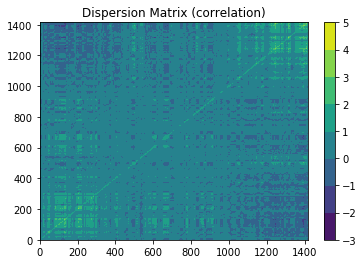

In [11]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [12]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 17 EOFs:
75.42% 

Cumulative variance explained by the first 4 EOFs:
48.97% 

1 	 29.17%
2 	 15.03%
3 	 4.77%
4 	 3.59%


### North Test

In [13]:
total_events = len(evecs)
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[30.267 15.592  4.951  3.724  3.408  3.181]
[29.17  15.028  4.771  3.589  3.285  3.066]
[28.074 14.463  4.592  3.454  3.162  2.951]


### Fig Variance

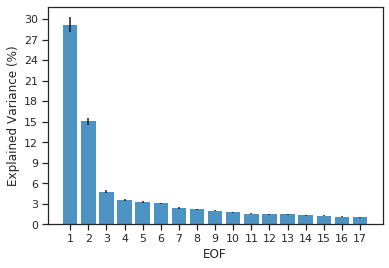

In [14]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,31,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [15]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(1416, 19)
[[ 0.295  0.831 -0.072 ...  0.084  0.044 -0.132]
 [ 0.42   0.749 -0.171 ...  0.107  0.06  -0.126]
 [ 0.201  0.768 -0.099 ...  0.056  0.007 -0.041]
 ...
 [ 0.703 -0.864  0.258 ...  0.119  0.062  0.127]
 [ 0.465 -0.768  0.428 ...  0.142 -0.077  0.053]
 [ 0.229 -0.689  0.436 ...  0.202 -0.097  0.082]]


In [16]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [22]:
evecs.shape

(1416, 1416)

In [33]:
var_list

[array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ...,

In [29]:
ntim, nlat, nlon = var1.shape

# Calculate principal components (spatial modes)
neofs = 4
pcs = calc_pcs(Xs_nomiss, evecs, neofs, mode=eofmode)
pcs.shape

# # project time EOF onto anomaly data
# pcs = np.ones([neofs, nlat*nlon]) * np.NaN
# for i in np.arange(neofs):
#     pcs[i,:] = np.matmul(Xs_nomiss, evecs[:,i])
 
# print(pcs.shape)

(4, 21600)

In [32]:
Xs_nomiss

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [28]:


# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

ValueError: cannot reshape array of size 65512 into shape (4,60,360)

### Fig. Spatial Modes

In [26]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons = ds_subset.lon.data
lats = ds_subset.lat.data
data = pcmodes[0][0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree(central_longitude=-179.5)
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

nan nan


/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN slice encountered
  # This is added back by InteractiveShellApp.init_path()


/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: 'bboxes' cannot be empty

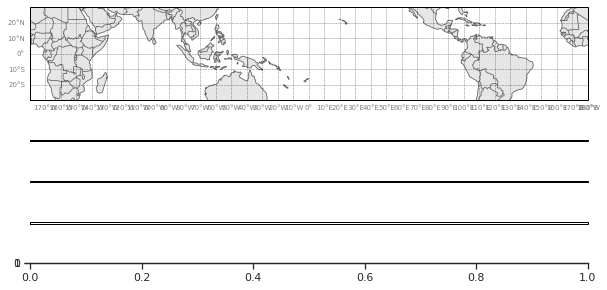

In [20]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 4
ncols = 1

# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='10%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
#     ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], grid=True)
    # Add contour fill plot for extratropics
#     clevs = np.arange(-3,3.5,.5)
    clevs = np.arange(-30,35,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

./results/EOF_ENSO.png


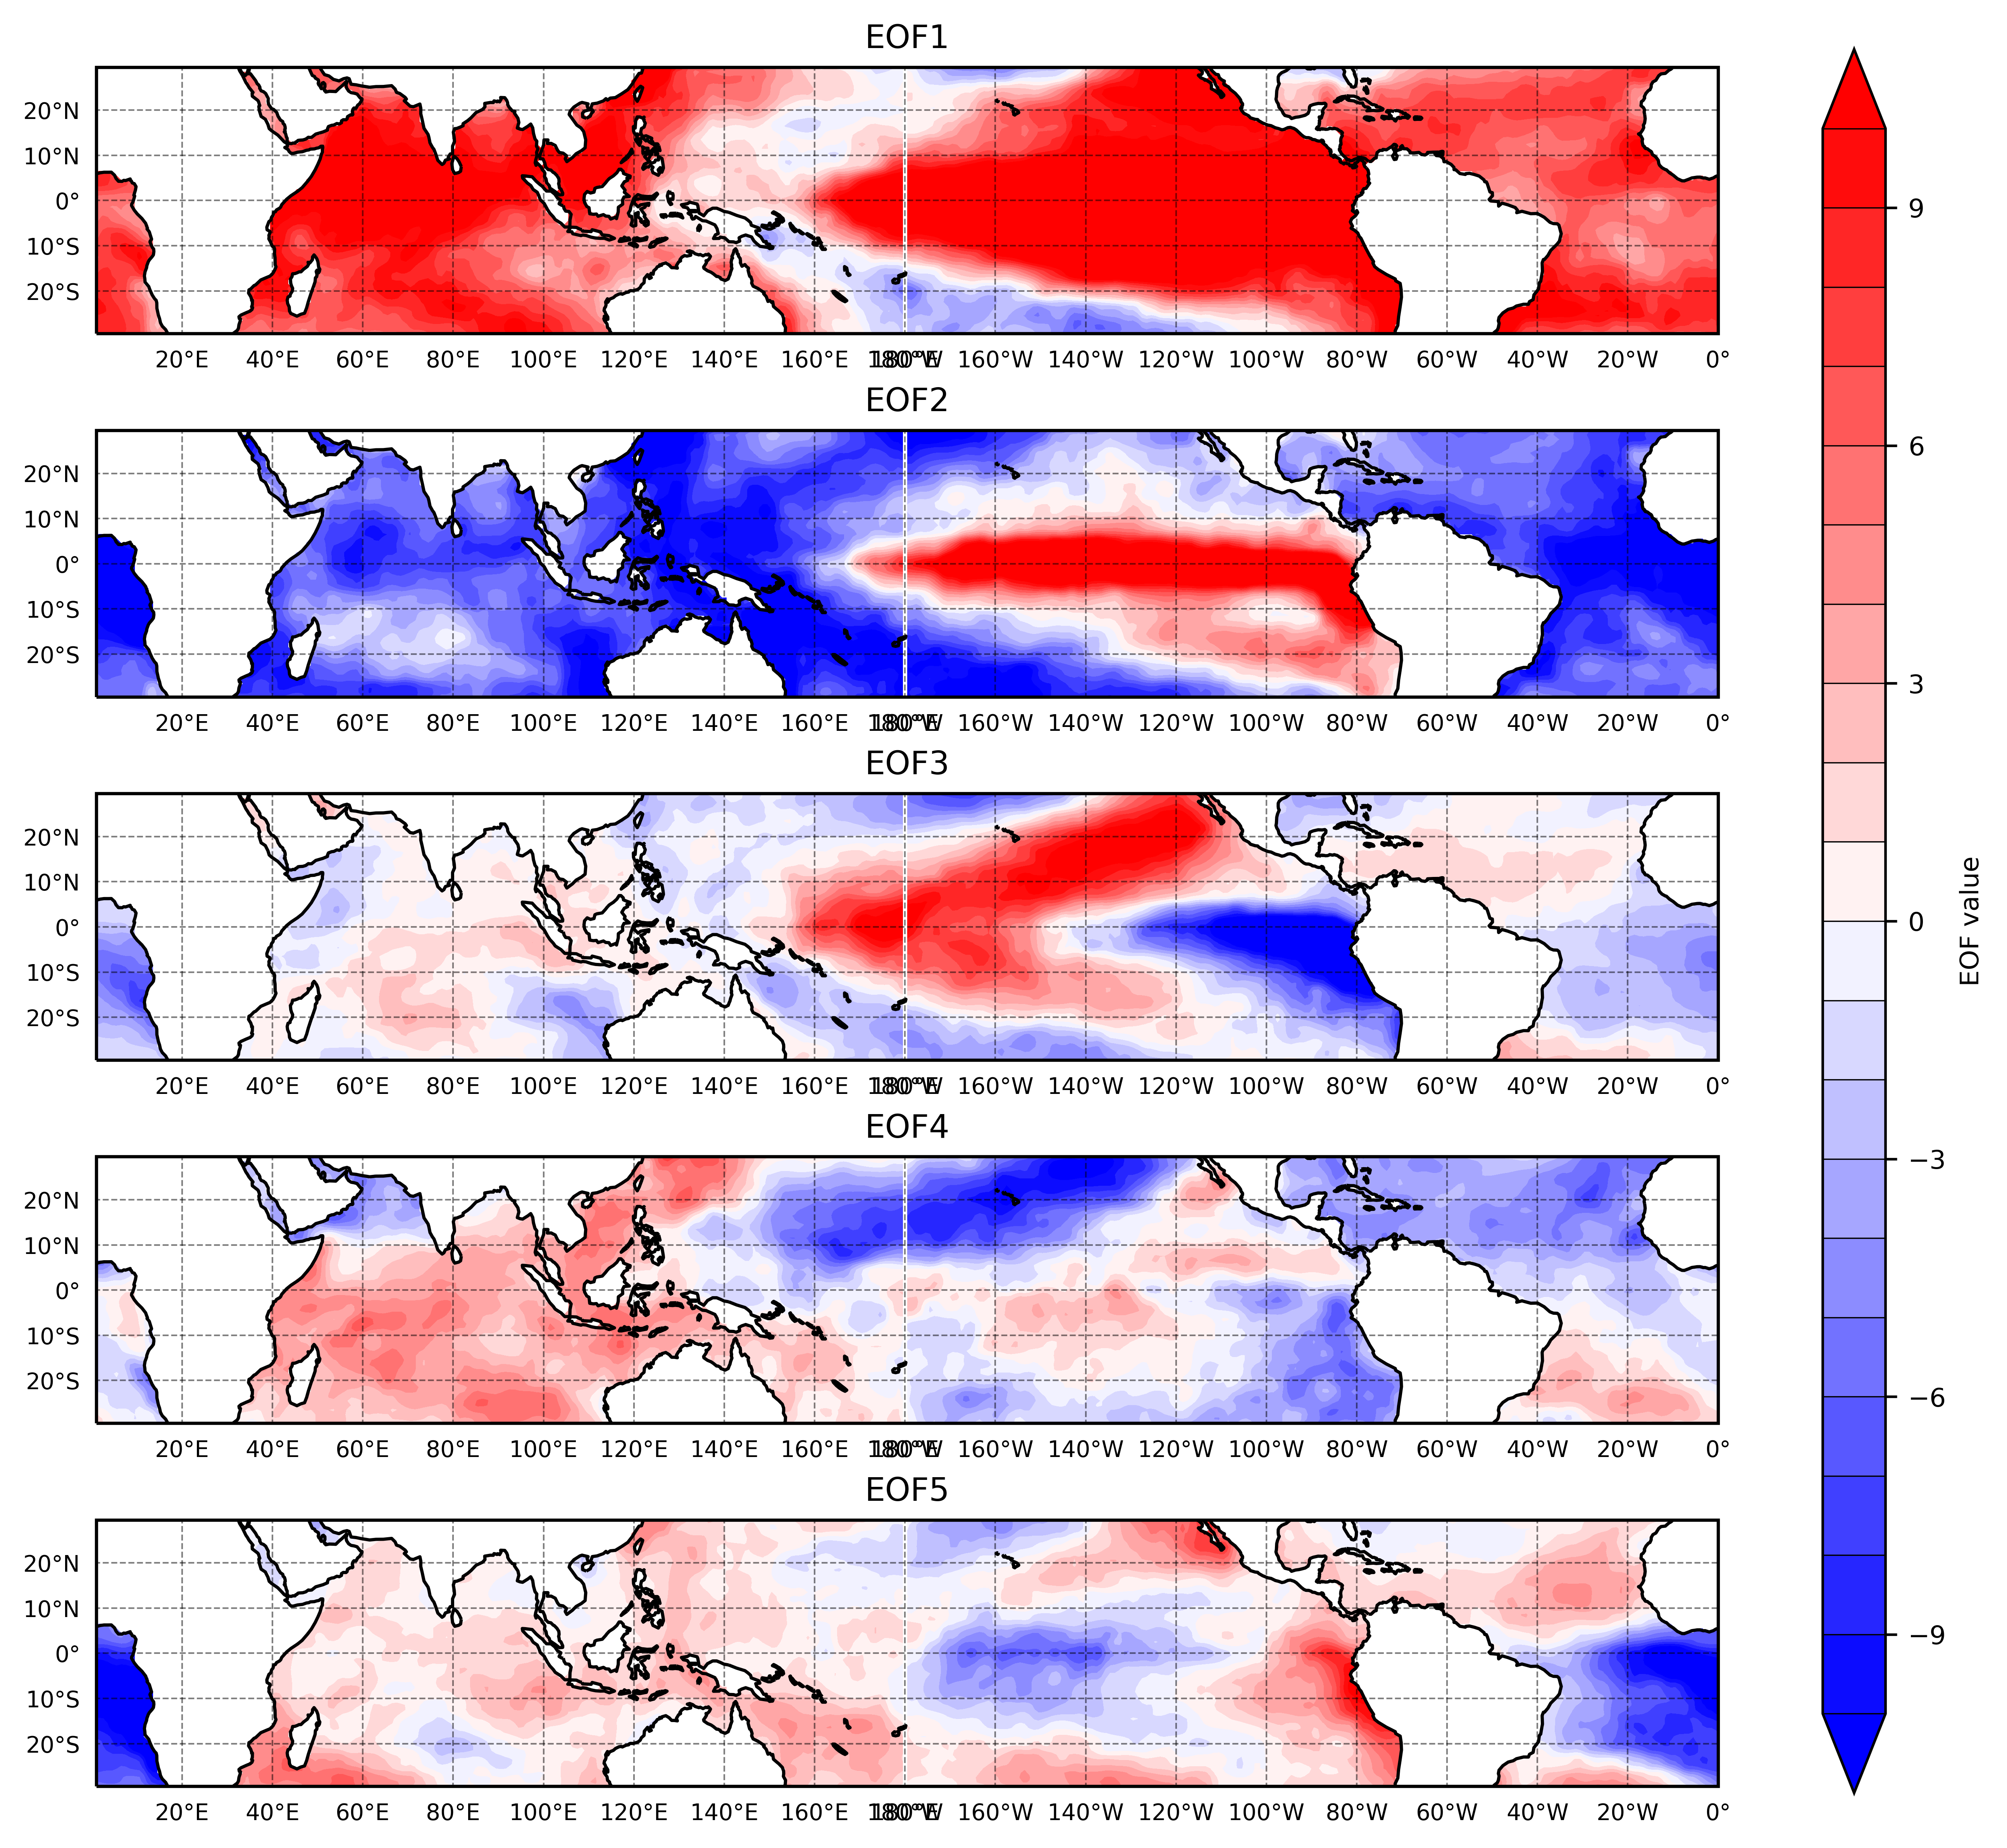

<Figure size 5400x6000 with 0 Axes>

In [20]:
fig = plt.figure(figsize=(9,10))
fig.dpi = 600
fname = './results/EOF_ENSO'
fmt = 'png'
results = EOF_reshape
subtitles = ['EOF1', 'EOF2', 'EOF3', 'EOF4', 'EOF5']

lats = sst['latitude']
lons = sst['longitude']

# clevs = np.arange(-0.025, 0.030, 0.005)
clevs = np.arange(-10, 11, 1)

for i in np.arange(len(results)):
    ax = plt.subplot(5, 1, i+1, projection=ccrs.PlateCarree(central_longitude=-179.5))
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree(central_longitude=-179.5))
    cf = ax.contourf(lons, lats, results[i], transform=ccrs.PlateCarree(),
                     extend='both', cmap='bwr', levels=clevs)
    ax.coastlines(linewidths=1.0)
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 40, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.95, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('EOF value', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

./results/PCA_ENSO.png


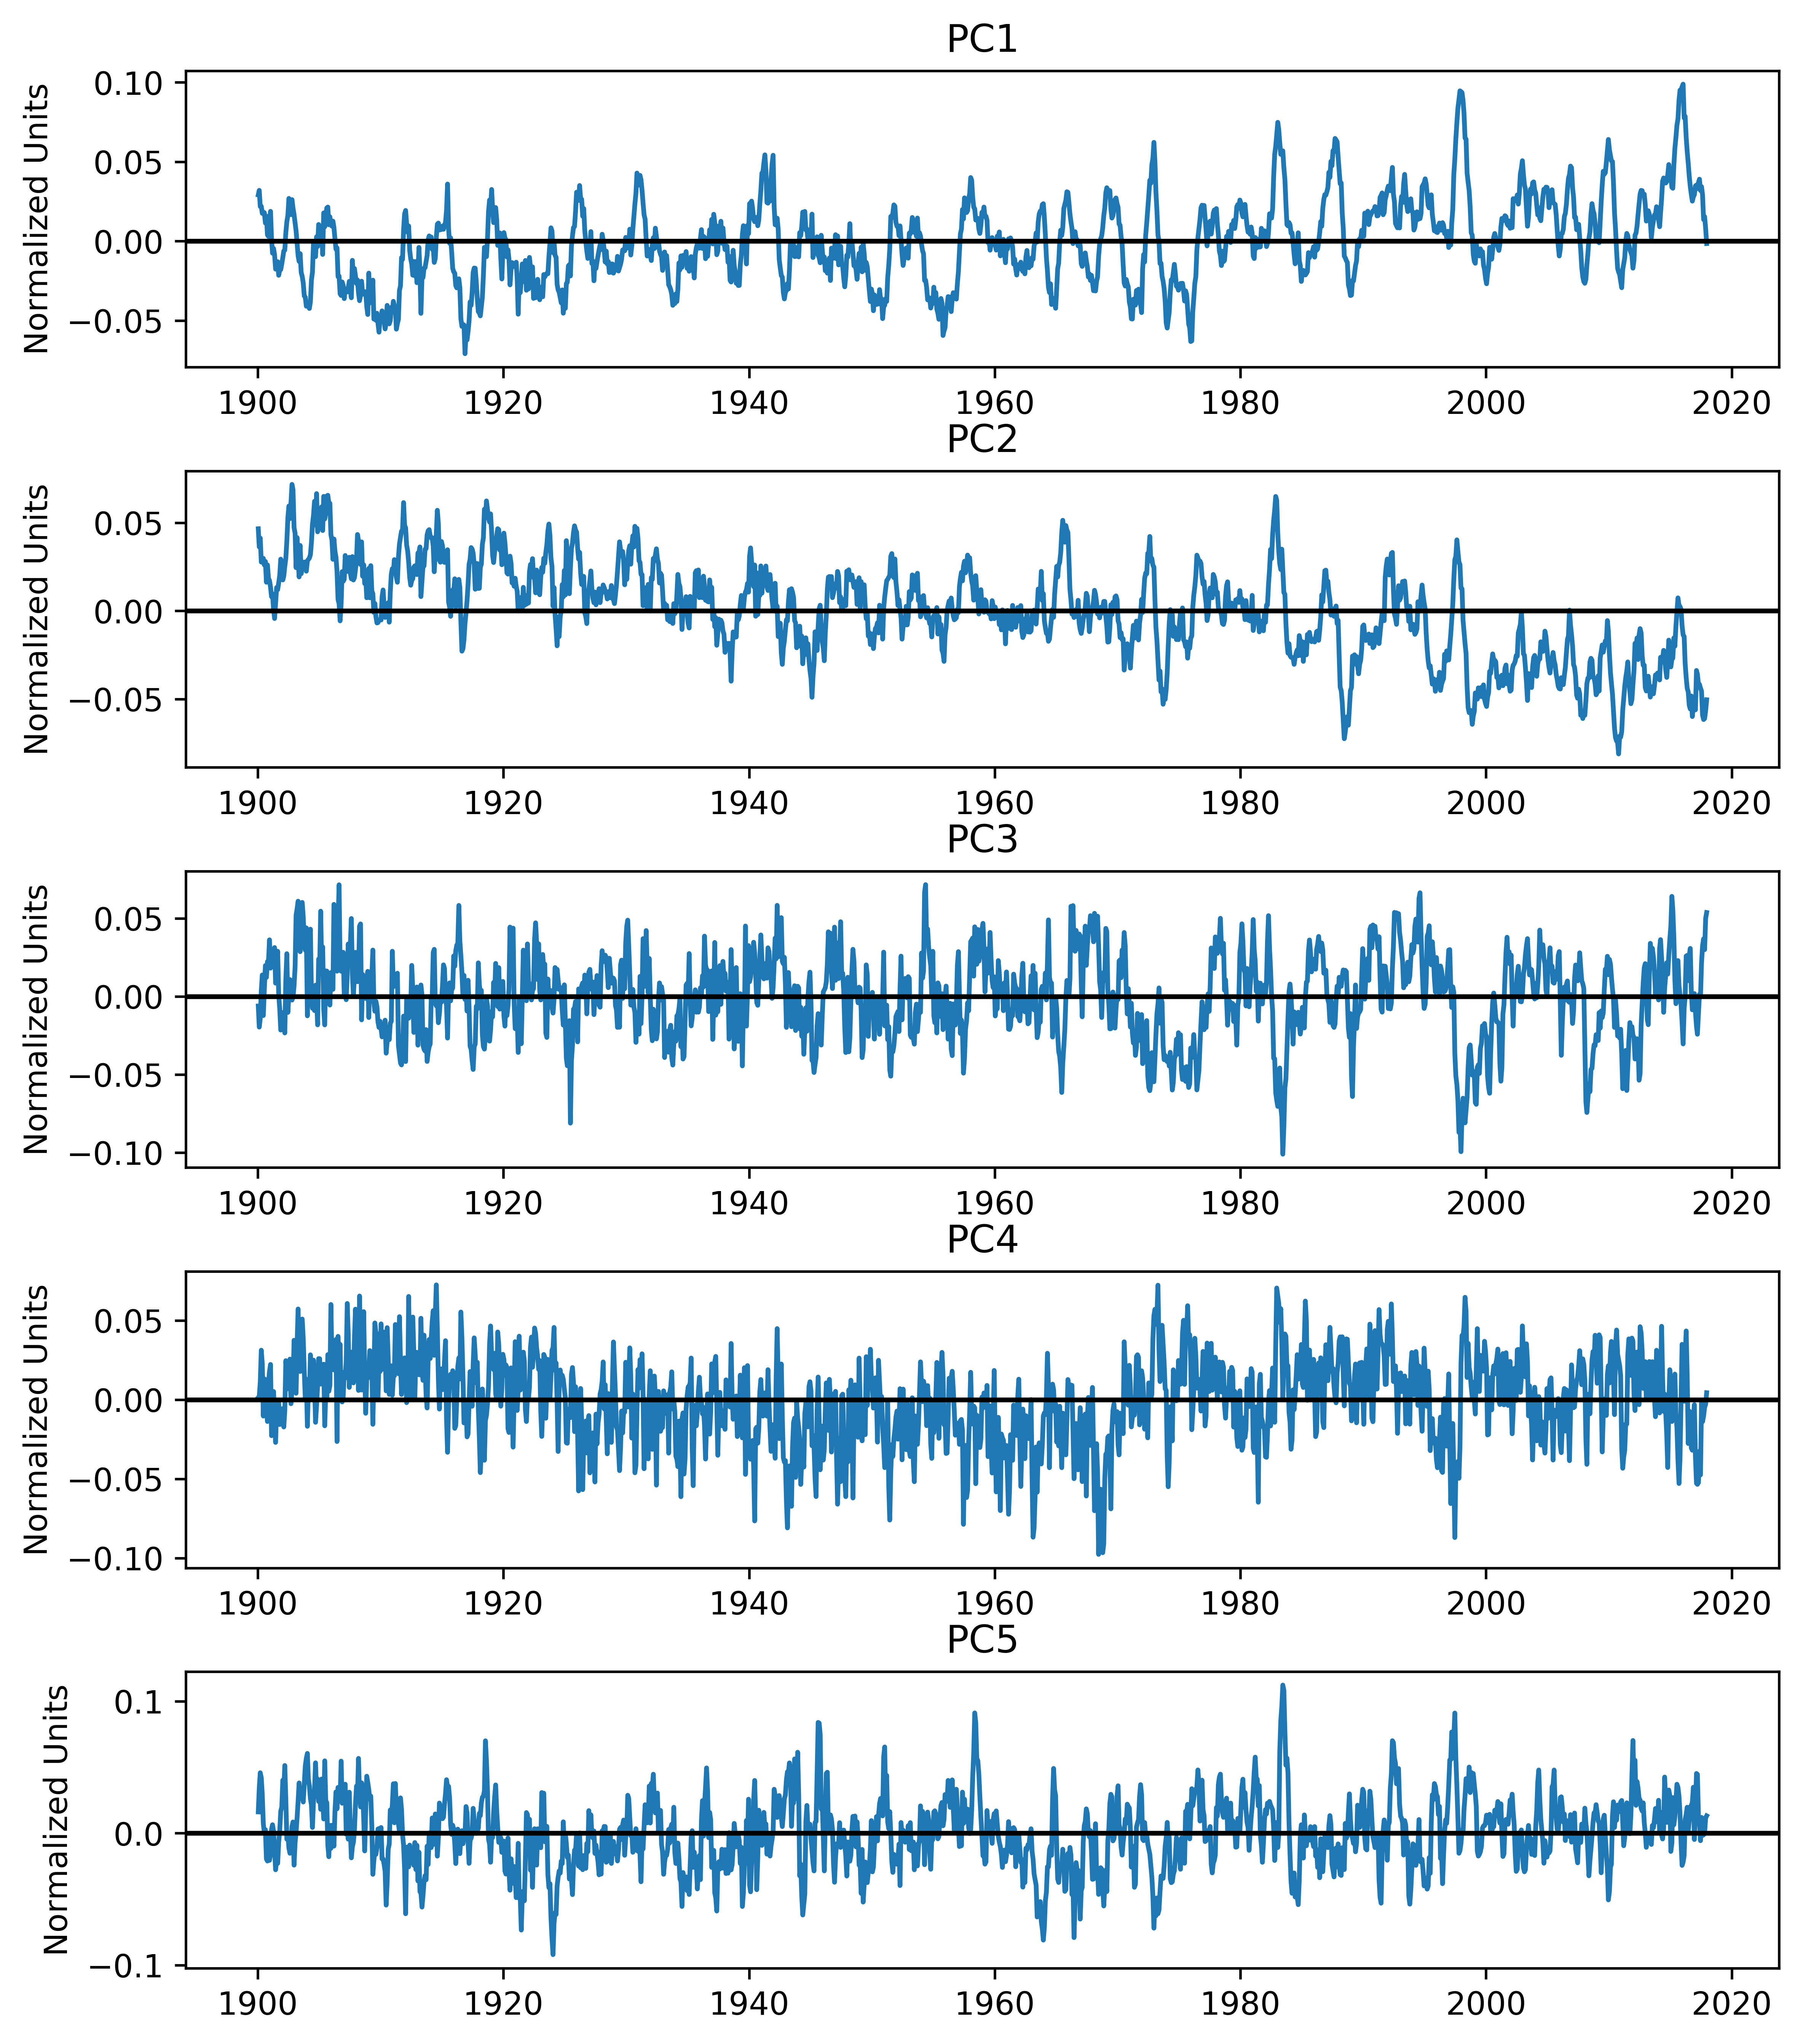

<Figure size 5400x6600 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 600
fname = './results/PCA_ENSO'
fmt = 'png'
results = v[:,:5]
subtitles = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

X, nplots = results.shape

for i in np.arange(nplots):
    ax = plt.subplot(5, 1, i+1)
    ax.plot_date(sst.time, results[:,i], '-')
    ax.axhline(0, color='k')
#     ax.set_ylim(-3, 3)
    ax.set_ylabel('Normalized Units')
    ax.set_title(subtitles[i], fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### EOF Separation

#### 2a. Using SST anomalies, compute the first auto-correlation for each gridpoint and obtain an average value. Estimate the effective sample size using:

$$ n' \equiv \frac{1 - \rho_{1}}{1 + \rho_{1}}$$

In [22]:
numtimes, numlats, numlons = weighted_data.shape
X1 = np.reshape(weighted_data[:-1, :,:].values, [numtimes-1, numlats*numlons])
X2 = np.reshape(weighted_data[1:, :,:].values, [numtimes-1, numlats*numlons])
X1.shape

autocorr1 = []
for i in np.arange(numlats*numlons):
    autocorr1.append(np.corrcoef(X1[:,i], X2[:,i]))

In [23]:
autocorr1_array = np.array(autocorr1)
autocorr1_mean = np.nanmean(autocorr1_array[:, 1, 0])

sample_size = numtimes*((1-autocorr1_mean)/(1+autocorr1_mean))
print(sample_size)

203.7068183710175


#### 2b. Use the North et al (1982) criteria to estimate the uncertainty in the eigenvalues estimation.

In [24]:
factor = np.sqrt(2.0 / sample_size)
errors = eig[:20] * factor
errors

array([10.36610498,  5.87707533,  1.76478434,  1.22403063,  1.12289226,
        1.01950911,  0.80583914,  0.70194303,  0.60789684,  0.59894886,
        0.51228882,  0.46784997,  0.4544669 ,  0.44358899,  0.41408033,
        0.34610255,  0.31479182,  0.28862503,  0.27258471,  0.26234797])

#### 2c. Plot eigenvalues 1-20 with the error bars calculated in item 2b above.

In [25]:
eig[:20]

array([104.61727118,  59.31288412,  17.81063598,  12.35321701,
        11.33250377,  10.28913574,   8.13272602,   7.08418106,
         6.13504387,   6.04473859,   5.17014432,   4.72165652,
         4.58659134,   4.47680876,   4.17900014,   3.49295169,
         3.1769562 ,   2.91287454,   2.75099164,   2.64767997])

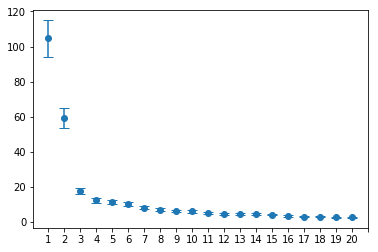

In [26]:
plt.errorbar(x=np.arange(0,20,1), y=eig[:20], yerr=errors, fmt='o', capsize=5)
f = plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))

 ### Questions

**1.	Why do you need to weight the SST values by the square of cosine of latitude?**

The data is in a regular latitude/longitude grid, and needs to be transformed into an equal-area grid. To accomplish this, each grid cell needs ot be weighted (i.e. multiply the time series at each grid box by the square root of the
cosine of latitude). This weighting function compensates for the decrease of the gridcell size in the higher latitude regions. If the gridcells are not area-weighted, it is possible that the EOFs can shift spatially, yielding different results. 

**2.	How many EOF modes are separated?**

The first three EOFs seem well separated from the rest of the EOFs, particularly when looking at the first 20 eigenvalues. 

**3.	Please give an interpretation for EOFs 1-5.**

EOF 1 is showing a consistent positive loading across the spatial area. It is possible that it is not showing much of a spatial pattern because it is reflecting the overall warming trend of SST, which was not removed from the dataset. The first PC is showing a positive trend, particularly after 1960. EOF 2 is showing a loading pattern similar to that of ENSO, with a elongated zone of positive loading in the equatorial Pacific and strong, negative loading in all other ocean basins. The second PC is showing almost an opposite trend of the first PC, with decreasing values post-1960. The third EOF is showing another familiar ENSO pattern, with positive loading in the east equatorial pacific, and a sideways v shaped negative loading around the zone of positive loading in the Pacific. PC 3 is showing a pattern of decreasing values for about 20 years, then a sharp incline, particularly after 1960. EOF 4 has two areas of strong negative loading - one in the northern Pacific, and one in the southeast Atlantic. The fifth EOF has positive loading patterns near the west coast of South America, as well as in the central Atlantic. South Atlantic is showing a region of strong negative loading, similar to that of EOF4.  
